In [1]:
import sys
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [30]:
path = "./dataset/Hindi/"

In [31]:
# Get the list of all directories and sort them
dir_list = next(os.walk(path))[1]
dir_list.sort()

In [32]:
dir_list

['001', '002', '003', '004']

 For each person segregate the genuine signatures from the forged signatures
 Genuine signatures are stored in the list "orig_groups"
 Forged signatures are stored in the list "forged_groups"

In [33]:
geniune_groups, forged_groups = [], []
for directory in dir_list:
    images = os.listdir(path+directory)
    images.sort()   
    images = [path+directory+'/'+x for x in images]
    forged_groups.append(images[:30]) # First 30 signatures in each folder are forrged (file_name contail 'F')
    geniune_groups.append(images[30:]) # Next 24 signatures are genuine (file_name contain 'G')

 Quick check to confirm we have data of all the 160 individuals

In [34]:
len(geniune_groups), len(forged_groups)

(4, 4)

In [35]:
geniune_lengths = [len(x) for x in geniune_groups]
forged_lengths = [len(x) for x in forged_groups]

In [36]:
print(geniune_lengths)

[24, 24, 24, 24]


In [37]:
print(forged_lengths)

[30, 30, 30, 30]


#### Training And Testing split
* Signatures of 1 people are used for training
* Signatures of 1 people are used for validation
* Signatures of 1 people are used for testing

In [38]:
geniune_train, geniune_val, geniune_test = geniune_groups[:2], geniune_groups[2:3],  geniune_groups[3:] 
forged_train, forged_val, forged_test = forged_groups[:2], forged_groups[2:3],  geniune_groups[3:]

In [39]:
# Delete unnecessary variables
#del geniune_groups, forged_groups
geniune_test

[['./dataset/Hindi/004/H-S-4-G-01.tif',
  './dataset/Hindi/004/H-S-4-G-02.tif',
  './dataset/Hindi/004/H-S-4-G-03.tif',
  './dataset/Hindi/004/H-S-4-G-04.tif',
  './dataset/Hindi/004/H-S-4-G-05.tif',
  './dataset/Hindi/004/H-S-4-G-06.tif',
  './dataset/Hindi/004/H-S-4-G-07.tif',
  './dataset/Hindi/004/H-S-4-G-08.tif',
  './dataset/Hindi/004/H-S-4-G-09.tif',
  './dataset/Hindi/004/H-S-4-G-10.tif',
  './dataset/Hindi/004/H-S-4-G-11.tif',
  './dataset/Hindi/004/H-S-4-G-12.tif',
  './dataset/Hindi/004/H-S-4-G-13.tif',
  './dataset/Hindi/004/H-S-4-G-14.tif',
  './dataset/Hindi/004/H-S-4-G-15.tif',
  './dataset/Hindi/004/H-S-4-G-16.tif',
  './dataset/Hindi/004/H-S-4-G-17.tif',
  './dataset/Hindi/004/H-S-4-G-18.tif',
  './dataset/Hindi/004/H-S-4-G-19.tif',
  './dataset/Hindi/004/H-S-4-G-20.tif',
  './dataset/Hindi/004/H-S-4-G-21.tif',
  './dataset/Hindi/004/H-S-4-G-22.tif',
  './dataset/Hindi/004/H-S-4-G-23.tif',
  './dataset/Hindi/004/H-S-4-G-24.tif']]

In [40]:
# All the images will be converted to the same size before processing
img_h, img_w = 155, 220

#### visualization

In [41]:
def visualize_sample_signature():
    '''Function to randomly select a signature from train set and
    print two genuine copies and one forged copy'''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
    k = np.random.randint(len(geniune_train))
    geniune_img_names = random.sample(geniune_train[k], 2)
    forged_img_name = random.sample(forged_train[k], 1)
    geniune_img1 = cv2.imread(geniune_img_names[0], 0)
    geniune_img2 = cv2.imread(geniune_img_names[1], 0)
    forged_img = cv2.imread(forged_img_name[0], 0)
    geniune_img1 = cv2.resize(geniune_img1, (img_w, img_h))
    geniune_img2 = cv2.resize(geniune_img2, (img_w, img_h))
    forged_img = cv2.resize(forged_img, (img_w, img_h))

    ax1.imshow(geniune_img1, cmap = 'gray')
    ax2.imshow(geniune_img2, cmap = 'gray')
    ax3.imshow(forged_img, cmap = 'gray')

    ax1.set_title('Genuine Signature')
    ax1.axis('off')
    ax2.set_title('Genuine Signature')
    ax2.axis('off')
    ax3.set_title('Forged Signature')
    ax3.axis('off')

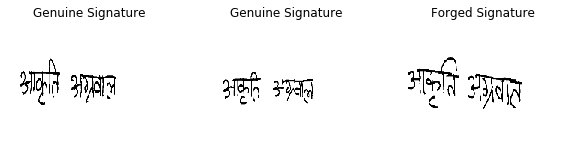

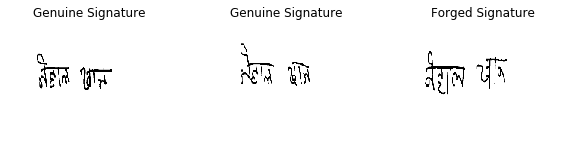

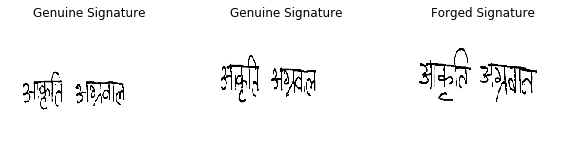

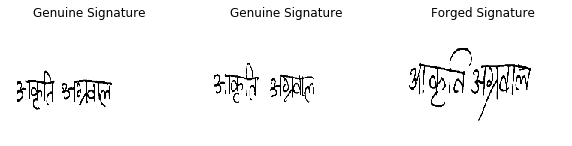

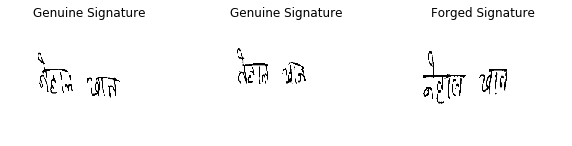

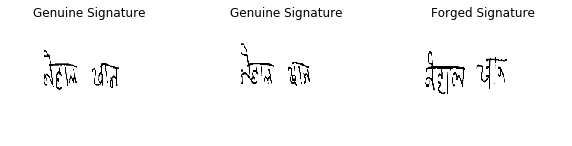

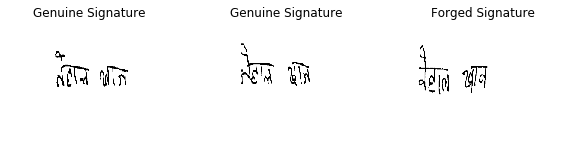

In [42]:
for _ in range(7):
    visualize_sample_signature()

In [43]:
def generate_batch(orig_groups, forg_groups, batch_size = 32):
    '''Function to generate a batch of data with batch_size number of data points
    Half of the data points will be Genuine-Genuine pairs and half will be Genuine-Forged pairs'''
    while True:
        orig_pairs = []
        forg_pairs = []
        gen_gen_labels = []
        gen_for_labels = []
        all_pairs = []
        all_labels = []
        
        # Here we create pairs of Genuine-Genuine image names and Genuine-Forged image names
        # For every person we have 24 genuine signatures, hence we have 
        # 24 choose 2 = 276 Genuine-Genuine image pairs for one person.
        # To make Genuine-Forged pairs, we pair every Genuine signature of a person
        # with 12 randomly sampled Forged signatures of the same person.
        # Thus we make 24 * 12 = 300 Genuine-Forged image pairs for one person.
        # In all we have 2 person's data in the training data.
        # Total no. of Genuine-Genuine pairs = 2 * 276 = 
        # Total number of Genuine-Forged pairs = 2 * 300 = 600
        for orig, forg in zip(orig_groups, forg_groups):
            orig_pairs.extend(list(itertools.combinations(orig, 2)))
            for i in range(len(forg)):
                forg_pairs.extend(list(itertools.product(orig[i:i+1], random.sample(forg, 12))))
        
        # Label for Genuine-Genuine pairs is 1
        # Label for Genuine-Forged pairs is 0
        gen_gen_labels = [1]*len(orig_pairs)
        gen_for_labels = [0]*len(forg_pairs)
        
        # Concatenate all the pairs together along with their labels and shuffle them
        all_pairs = orig_pairs + forg_pairs
        all_labels = gen_gen_labels + gen_for_labels
        del orig_pairs, forg_pairs, gen_gen_labels, gen_for_labels
        all_pairs, all_labels = shuffle(all_pairs, all_labels)
        
        # Note the lists above contain only the image names and
        # actual images are loaded and yielded below in batches
        # Below we prepare a batch of data points and yield the batch
        # In each batch we load "batch_size" number of image pairs
        # These images are then removed from the original set so that
        # they are not added again in the next batch.
            
        k = 0
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
        targets=np.zeros((batch_size,))
        for ix, pair in enumerate(all_pairs):
            img1 = cv2.imread(pair[0], 0)
            img2 = cv2.imread(pair[1], 0)
            img1 = cv2.resize(img1, (img_w, img_h))
            img2 = cv2.resize(img2, (img_w, img_h))
            img1 = np.array(img1, dtype = np.float64)
            img2 = np.array(img2, dtype = np.float64)
            img1 /= 255
            img2 /= 255
            img1 = img1[..., np.newaxis]
            img2 = img2[..., np.newaxis]
            pairs[0][k, :, :, :] = img1
            pairs[1][k, :, :, :] = img2
            targets[k] = all_labels[ix]
            k += 1
            if k == batch_size:
                yield pairs, targets
                k = 0
                pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]
                targets=np.zeros((batch_size,))

#### Euclidean Distance

In [44]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

In [45]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

#### Loss Function

In [46]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))



In [47]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

#### Building Network

In [48]:
# tensorflow model
def create_base_network(input_shape):
    '''Base Siamese Network'''
    seq = Sequential()
    seq.add(Conv2D(96, (11, 11), activation='relu', name='conv1_1', strides=(4,4), input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2),))
    
    seq.add(Conv2D(256, (5, 5), activation='relu', name='conv2_1', strides=(1, 1), kernel_initializer='glorot_uniform'))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(384, (3, 3), activation='relu', name='conv3_1', strides=(1, 1), kernel_initializer='glorot_uniform'))
    seq.add(ZeroPadding2D((1, 1)))
    
    seq.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2', strides=(1, 1), kernel_initializer='glorot_uniform'))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    return seq


In [49]:
input_shape=(img_h, img_w, 1)

In [51]:
# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
emd_a = base_network(input_a)
emd_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([emd_a, emd_b])

model = Model(inputs=[input_a, input_b], outputs=distance)

In [52]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 155, 220, 1) 0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 128)          6461084     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0           sequential[1][0]             

In [53]:
batch_size = 128
num_train_samples = 276*2 + 300*2
num_val_samples = num_test_samples = 276*1 + 300*1
num_train_samples, num_val_samples, num_test_samples

(1152, 576, 576)

In [54]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(lr=1e-4, rho=0.9, epsilon=1e-08)
model.compile(loss=contrastive_loss, optimizer=rms)

In [211]:
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/signet-bhsig260-{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [212]:
results = model.fit(generate_batch(geniune_train, forged_train, batch_size),
                              steps_per_epoch = num_train_samples//batch_size,
                              epochs = 5,
                              validation_data = generate_batch(geniune_val, forged_val, batch_size),
                              validation_steps = num_val_samples//batch_size,
                              callbacks = callbacks)

Epoch 1/5
4/4 [==============================] - ETA: 0s - loss: 44.2953
Epoch 00001: saving model to ./Weights/signet-bhsig260-001.h5
4/4 [==============================] - 50s 12s/step - loss: 44.2953 - val_loss: 1.4045 - lr: 1.0000e-04
Epoch 2/5
4/4 [==============================] - ETA: 0s - loss: 2.5957
Epoch 00002: saving model to ./Weights/signet-bhsig260-002.h5
4/4 [==============================] - 54s 13s/step - loss: 2.5957 - val_loss: 1.3839 - lr: 1.0000e-04
Epoch 3/5
4/4 [==============================] - ETA: 0s - loss: 1.8193
Epoch 00003: saving model to ./Weights/signet-bhsig260-003.h5
4/4 [==============================] - 51s 13s/step - loss: 1.8193 - val_loss: 1.4050 - lr: 1.0000e-04
Epoch 4/5
4/4 [==============================] - ETA: 0s - loss: 1.5841
Epoch 00004: saving model to ./Weights/signet-bhsig260-004.h5
4/4 [==============================] - 59s 15s/step - loss: 1.5841 - val_loss: 1.3840 - lr: 1.0000e-04
Epoch 5/5
4/4 [==============================] - E

In [63]:
model.load_weights("models/signature_60epoch.h5")

In [64]:
def compute_accuracy_roc(predictions, labels):
    '''Compute ROC accuracy with a range of thresholds on distances.
    '''
    dmax = np.max(predictions)
    dmin = np.min(predictions)
    nsame = np.sum(labels == 1)
    ndiff = np.sum(labels == 0)
   
    step = 0.01
    max_acc = 0
    best_thresh = -1
   
    for d in np.arange(dmin, dmax+step, step):
        idx1 = predictions.ravel() <= d
        idx2 = predictions.ravel() > d
       
        tpr = float(np.sum(labels[idx1] == 1)) / nsame       
        tnr = float(np.sum(labels[idx2] == 0)) / ndiff
        acc = 0.5 * (tpr + tnr)       
#       print ('ROC', acc, tpr, tnr)
       
        if (acc > max_acc):
            max_acc, best_thresh = acc, d
           
    return max_acc, best_thresh

In [65]:
test_gen = generate_batch(geniune_test, forged_test, 1)
pred, tr_y = [], []
for i in range(num_test_samples):
    (img1, img2), label = next(test_gen)
    tr_y.append(label)
    pred.append(model.predict([img1, img2])[0][0])

In [66]:
tr_acc, threshold = compute_accuracy_roc(np.array(pred), np.array(tr_y))
tr_acc, threshold

(0.5142857142857142, 0.27)

In [67]:
def predict_score():
    '''Predict distance score and classify test images as Genuine or Forged'''
    test_point, test_label = next(test_gen)
    img1, img2 = test_point[0], test_point[1]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
    ax1.imshow(np.squeeze(img1), cmap='gray')
    ax2.imshow(np.squeeze(img2), cmap='gray')
    ax1.set_title('Genuine')
    if test_label == 1:
        ax2.set_title('Genuine')
    else:
        ax2.set_title('Forged')
    ax1.axis('off')
    ax2.axis('off')
    plt.show()
    result = model.predict([img1, img2])
    diff = result[0][0]
    print("Difference Score = ", diff)
    if diff > threshold:
        print("Its a Forged Signature")
    else:
        print("Its a Genuine Signature")

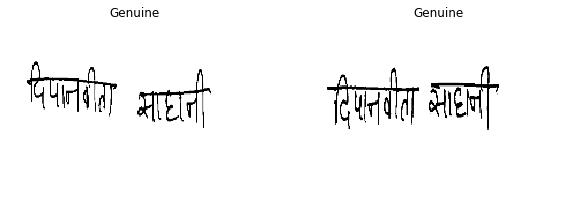

Difference Score =  0.14556591
Its a Genuine Signature


In [68]:
predict_score()

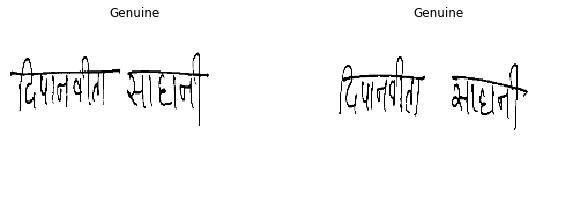

Difference Score =  0.06720986
Its a Genuine Signature


In [69]:
predict_score()

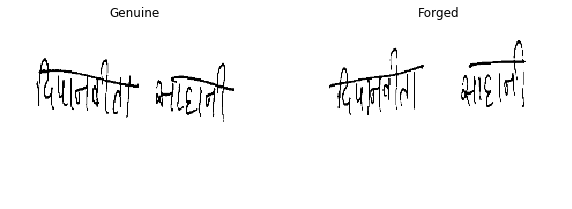

Difference Score =  0.15502147
Its a Genuine Signature


In [70]:
predict_score()

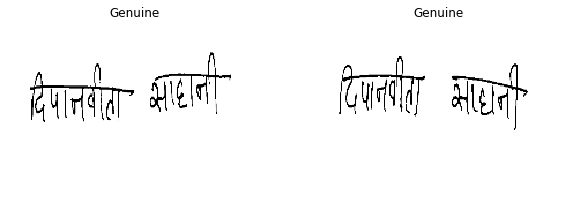

Difference Score =  0.09994155
Its a Genuine Signature


In [71]:
predict_score()

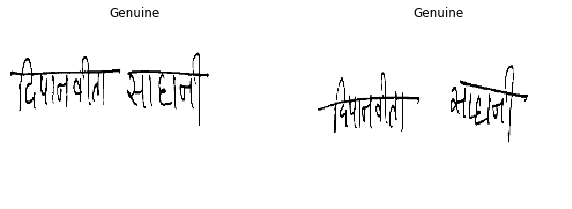

Difference Score =  0.15814094
Its a Genuine Signature


In [72]:
predict_score()